# **Computational Physics**
## Homework 3
### Stefan-Boltzmann constant evaluation
> Author : Yuan-Yen Peng    
> License: MIT    
> Email  : garyphys0915@gapp.nthu.edu.tw     
> Date   : May 08, 2023    
> Version: 2.1

In [17]:
import numpy as np
from numba import njit
import integrator

#### (a), (b) Customized default class    
Use midpoint method and trapezoidal method (also check with the simpson method)

In [18]:
import scipy.constants as const
import warnings

pi = const.pi
h = const.h
c = const.c
k = const.k
T = 6000
# ignore large number or (small number) in exponential
warnings.filterwarnings('ignore')

In [19]:
@njit(parallel=True)
def boltz(x):
  tor = 1e-20
  nu = 2*h*x**3
  de = c**2*(np.exp(h*x/(k*T)) - 1) + tor
  return (nu/de)*pi/T**4

In [20]:
N = 10_000_000
# use large upper bound as an infinity
upper = int(1e20)

In [21]:
integrate = integrator.Integrator(func=boltz)
my_mid   = integrate.midpoint(a=0, b=upper, N=N)
my_trapz = integrate.trapz(a=0, b=upper, N=N)
my_simp  = integrate.trapz(a=0, b=upper, N=N)
print("Use default python (customized class)")
print(f"Mid   result: {my_mid}")
print(f"Trapz result: {my_trapz}")
print(f"Simp  result: {my_simp}")
del my_mid, my_trapz, my_simp

Use default python (customized class)
Mid   result: 5.670374549497005e-08
Trapz result: 5.670374270255775e-08
Simp  result: 5.670374270255775e-08


#### (c), (d) Numpy methods
Use `np.sum()` and `np.trapz()`

In [22]:
dx = upper/N
x = np.linspace(0, upper, N)
np_sum = np.sum(boltz(x)*dx)
print(f"Use numpy sum: {np_sum}")
np_trapz = np.trapz(boltz(x), dx=dx)
print(f"Use numpy trapz: {np_trapz}")
del np_sum, np_trapz

Use numpy sum: 5.670373703218297e-08
Use numpy trapz: 5.670373703218297e-08


#### (e) Use Monte Carlo method

In [23]:
@njit(parallel=True)
def kernel(y: np.ndarray, y_boltz: np.ndarray) -> tuple:
  inside, tot = 0, 0
  for i in range(N):
    if y[i] <= y_boltz[i]:
      inside +=1
    tot += 1
  return inside, tot

In [24]:
rng = np.random.default_rng(seed=2252)
x       = upper*rng.random(N)
y_boltz = np.array([boltz(i) for i in x])
y       = y_boltz.max()*rng.random(N)
# use numba to accelarate
inside, tot = kernel(y, y_boltz)
area = upper*y_boltz.max()*(inside/tot)
print(f"Use MC method with sample size N = {N}\nThe answer is: {area} \n")
del x, y, y_boltz, area

Use MC method with sample size N = 10000000
The answer is: 6.353521088180136e-08 



#### (f) Measure the numerical errors as a function of the sample size

In [25]:
N_test = [1_000, 10_000, 100_000, 1_000_000, 10_000_000, 100_000_000]
arr_area = np.empty(len(N_test))
for ind, n in enumerate(N_test):
  x       = upper*rng.random(n)
  y_boltz = np.array([boltz(i) for i in x])
  y       = y_boltz.max()*rng.random(n)
  # use numba to accelarate
  inside, tot = kernel(y, y_boltz)
  area = upper*y_boltz.max()*(inside/tot)
  arr_area[ind] = area
  print(f"Use MC method with sample size N = {n}\n  The answer is: {area} \n")

Use MC method with sample size N = 1000
 The answer is: 0.0 

Use MC method with sample size N = 10000
 The answer is: 1.2265898354912354e-26 

Use MC method with sample size N = 100000
 The answer is: 6.238796085509831e-07 

Use MC method with sample size N = 1000000
 The answer is: 0.008848555693403612 

Use MC method with sample size N = 10000000
 The answer is: 6.405920149274166e-08 

Use MC method with sample size N = 100000000
 The answer is: 5.559556728863976e-08 



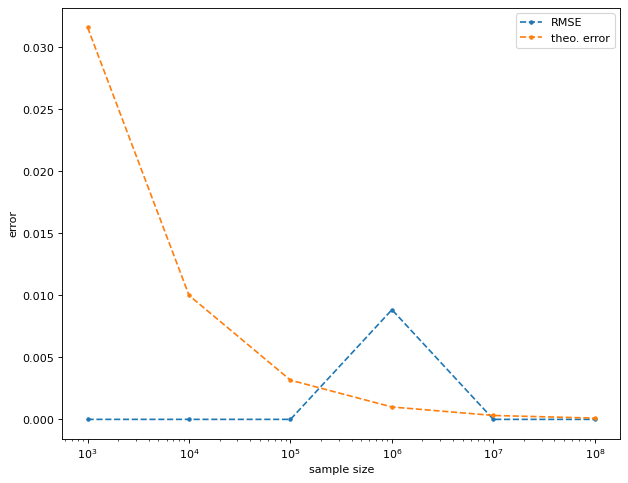

In [26]:
from matplotlib import pyplot as plt

rmse = lambda test, exact: np.sqrt(np.mean((test - exact)**2))
err  = [1/np.sqrt(n) for n in N_test]
arr_rmse = [rmse(x, const.sigma) for x in arr_area]

fig = plt.figure(figsize=(9,7), dpi=80)
plt.plot(N_test, arr_rmse, '--.', label="RMSE")
plt.plot(N_test, err, '--.', label="theo. error")
plt.xticks(N_test)
plt.semilogx()
plt.xlabel("sample size")
plt.ylabel("error")
plt.legend(loc="best")